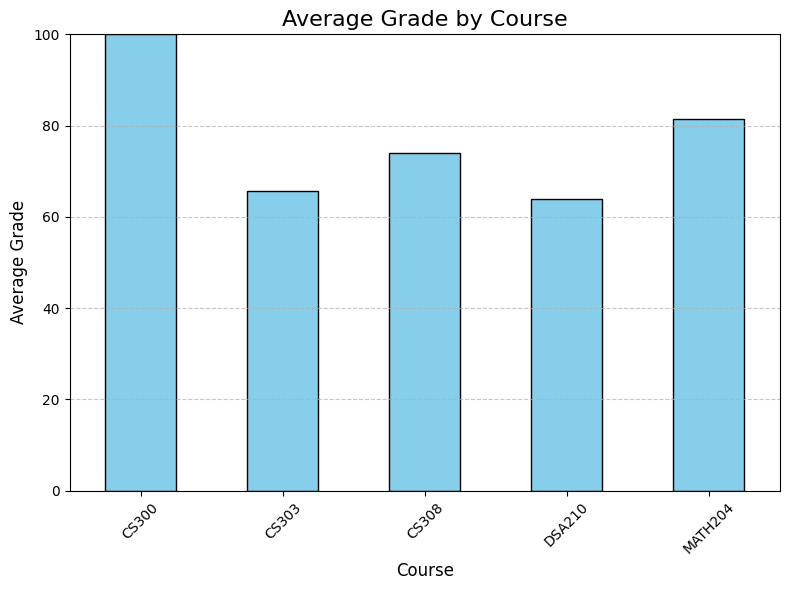

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define the processed_data directory
processed_data = Path("processed_data")  # Update this path if needed

# Create DataFrames
courses = ['CS300', 'CS303', 'CS308', 'DSA210', 'MATH204']
dfs = []
for course in courses:
    df = pd.read_csv(processed_data / f'{course}_data.txt')  # Load data for each course
    dfs.append(df)

grades_df = pd.DataFrame([  # Grade data for the courses
    ['24.11.2024', 'CS300', 'MT1', 100],
    ['02.11.2024', 'CS303', 'MT1', 82],
    ['14.12.2024', 'CS303', 'MT2', 56],
    ['3.01.2025', 'CS303', 'Final', 59],
    ['30.11.2024', 'CS308', 'MT1', 74],
    ['10.11.2024', 'DSA210', 'MT1', 64],
    ['3.11.2024', 'MATH204', 'MT1', 91],
    ['1.12.2024', 'MATH204', 'MT2', 72]
], columns=['DATE', 'COURSE', 'EXAM', 'GRADE'])

# Calculate average grades by course
avg_grades = grades_df.groupby('COURSE')['GRADE'].mean()

# Plot the average grades
plt.figure(figsize=(8, 6))
avg_grades.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Grade by Course', fontsize=16)
plt.xlabel('Course', fontsize=12)
plt.ylabel('Average Grade', fontsize=12)
plt.ylim(0, 100)  # Grades are typically out of 100
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [20]:
def perform_statistical_analysis(df_list, grades_df):
    df = pd.concat(df_list)
    df = df[df['TOTAL MINUTES STUDIED'] > 0].copy()
    
    # Test H₁a: Room vs IC study effectiveness
    location_analysis = {}
    for course in df['COURSE'].unique():
        course_data = df[df['COURSE'] == course].copy()
        
        # Calculate average study time per day for each location
        room_daily = course_data[course_data['STUDY LOCATION'] == 'Room'].groupby('DATE')['TOTAL MINUTES STUDIED'].sum()
        ic_daily = course_data[course_data['STUDY LOCATION'] == 'IC'].groupby('DATE')['TOTAL MINUTES STUDIED'].sum()
        
        if len(room_daily) > 0 and len(ic_daily) > 0:
            t_stat, p_val = stats.ttest_ind(room_daily, ic_daily)
            location_analysis[course] = {
                'statistic': t_stat,
                'p_value': p_val,
                'room_mean': room_daily.mean(),
                'ic_mean': ic_daily.mean()
            }
    
    # Test H₁b: Time block effectiveness
    time_blocks = ['09.00 - 12.00', '12.00 - 17.00', '17.00 - 21.00', '21.00 - 00.00', '00.00 - 03.00']
    
    time_analysis = {}
    for course in df['COURSE'].unique():
        course_data = df[df['COURSE'] == course].copy()
        course_grade = grades_df[grades_df['COURSE'] == course]['GRADE'].mean()
        
        block_stats = {}
        for block in time_blocks:
            if block in course_data.columns:
                period_time = course_data[block]
                # Create array of same length as period_time filled with course grade
                grade_array = np.full(len(period_time), course_grade)
                
                if period_time.std() > 0 and len(period_time) > 1:
                    correlation, p_value = pearsonr_safe(period_time, grade_array)
                    block_stats[block] = {
                        'correlation': correlation,
                        'p_value': p_value,
                        'mean_study_time': period_time.mean()
                    }
        
        if block_stats:
            time_analysis[course] = block_stats
    
    return {
        'location_analysis': location_analysis,
        'time_analysis': time_analysis
    }

def print_statistical_results(stats_results):
    alpha = 0.05
    
    print("\nH₁a: Study Location Analysis")
    print("H₀: No difference between Room and IC study effectiveness")
    print("-" * 60)
    for course, result in stats_results['location_analysis'].items():
        print(f"\n{course}:")
        print(f"Room mean study time: {result['room_mean']:.2f} minutes")
        print(f"IC mean study time: {result['ic_mean']:.2f} minutes")
        print(f"t-statistic: {result['statistic']:.3f}")
        print(f"p-value: {result['p_value']:.3f}")
        print(f"Conclusion: {'Reject' if result['p_value'] < alpha else 'Fail to reject'} H₀")
    
    print("\nH₁b: Time Block Analysis")
    print("H₀: No correlation between time block study duration and grades")
    print("-" * 60)
    for course, blocks in stats_results['time_analysis'].items():
        print(f"\n{course}:")
        for block, stats in blocks.items():
            print(f"\n{block}:")
            print(f"Mean study time: {stats['mean_study_time']:.2f} minutes")
            corr = stats['correlation']
            pval = stats['p_value']
            print(f"Correlation with grades: {corr if corr is not None else 'Not enough data'}")
            print(f"p-value: {pval if pval is not None else 'Not enough data'}")
            print(f"Conclusion: {'Reject' if pval is not None and pval < alpha else 'Fail to reject'} H₀")

# Run the updated analysis and print results
stats_results = perform_statistical_analysis(dfs, grades_df)
print_statistical_results(stats_results)



H₁a: Study Location Analysis
H₀: No difference between Room and IC study effectiveness
------------------------------------------------------------

CS300:
Room mean study time: 152.71 minutes
IC mean study time: 112.31 minutes
t-statistic: 1.224
p-value: 0.232
Conclusion: Fail to reject H₀

CS303:
Room mean study time: 143.42 minutes
IC mean study time: 178.92 minutes
t-statistic: -1.530
p-value: 0.140
Conclusion: Fail to reject H₀

CS308:
Room mean study time: 163.58 minutes
IC mean study time: 128.60 minutes
t-statistic: 0.920
p-value: 0.369
Conclusion: Fail to reject H₀

DSA210:
Room mean study time: 115.18 minutes
IC mean study time: 156.54 minutes
t-statistic: -1.298
p-value: 0.208
Conclusion: Fail to reject H₀

MATH204:
Room mean study time: 106.22 minutes
IC mean study time: 122.85 minutes
t-statistic: -0.522
p-value: 0.607
Conclusion: Fail to reject H₀

H₁b: Time Block Analysis
H₀: No correlation between time block study duration and grades
-----------------------------------

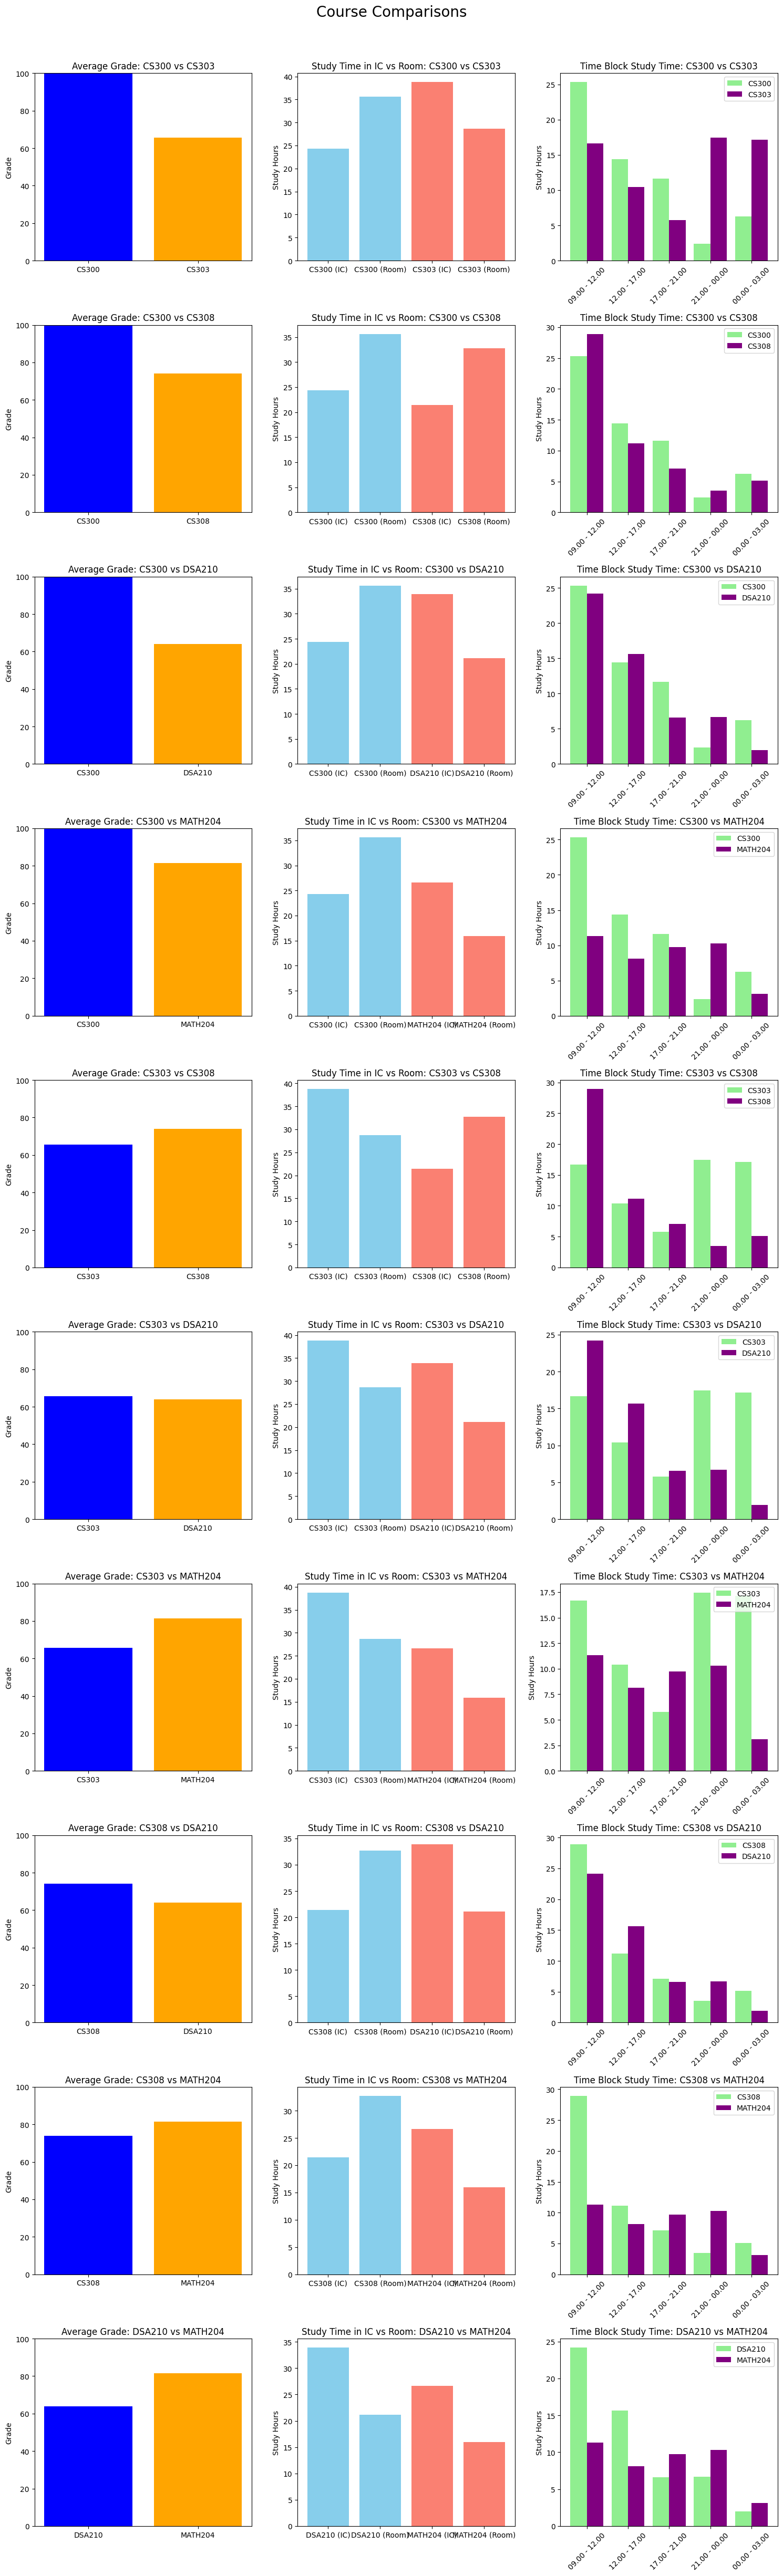

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_course_comparisons(course_metrics, combinations):
    # Prepare data for plotting
    fig, axes = plt.subplots(len(combinations), 3, figsize=(15, 5 * len(combinations)))
    fig.suptitle('Course Comparisons', fontsize=20)
    
    if len(combinations) == 1:
        axes = [axes]  # Ensure axes is iterable for single combination
    
    for idx, (course1, course2) in enumerate(combinations):
        metrics1 = course_metrics[course1]
        metrics2 = course_metrics[course2]
        
        # Plot 1: Average grades
        axes[idx][0].bar([course1, course2], [metrics1['avg_grade'], metrics2['avg_grade']], color=['blue', 'orange'])
        axes[idx][0].set_title(f'Average Grade: {course1} vs {course2}')
        axes[idx][0].set_ylabel('Grade')
        axes[idx][0].set_ylim(0, 100)
        
        # Plot 2: Study time in IC vs Room
        ic_room_data = [
            [metrics1['ic_hours'], metrics1['room_hours']],
            [metrics2['ic_hours'], metrics2['room_hours']]
        ]
        axes[idx][1].bar([course1 + " (IC)", course1 + " (Room)"], ic_room_data[0], color='skyblue')
        axes[idx][1].bar([course2 + " (IC)", course2 + " (Room)"], ic_room_data[1], color='salmon')
        axes[idx][1].set_title(f'Study Time in IC vs Room: {course1} vs {course2}')
        axes[idx][1].set_ylabel('Study Hours')
        
        # Plot 3: Study time in time blocks
        time_blocks = ['09.00 - 12.00', '12.00 - 17.00', '17.00 - 21.00', '21.00 - 00.00', '00.00 - 03.00']
        time_block_hours1 = [metrics1['time_block_hours'][block] for block in time_blocks]
        time_block_hours2 = [metrics2['time_block_hours'][block] for block in time_blocks]
        x = np.arange(len(time_blocks))
        
        axes[idx][2].bar(x - 0.2, time_block_hours1, width=0.4, label=course1, color='lightgreen')
        axes[idx][2].bar(x + 0.2, time_block_hours2, width=0.4, label=course2, color='purple')
        axes[idx][2].set_xticks(x)
        axes[idx][2].set_xticklabels(time_blocks, rotation=45)
        axes[idx][2].set_title(f'Time Block Study Time: {course1} vs {course2}')
        axes[idx][2].set_ylabel('Study Hours')
        axes[idx][2].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Define the 10 combinations of courses
combinations = [
    ('CS300', 'CS303'),
    ('CS300', 'CS308'),
    ('CS300', 'DSA210'),
    ('CS300', 'MATH204'),
    ('CS303', 'CS308'),
    ('CS303', 'DSA210'),
    ('CS303', 'MATH204'),
    ('CS308', 'DSA210'),
    ('CS308', 'MATH204'),
    ('DSA210', 'MATH204')
]

# Run the plot function
results = analyze_study_patterns(dfs, grades_df)
course_metrics = results['course_metrics']
plot_course_comparisons(course_metrics, combinations)


In [25]:
def find_significant_differences(course_metrics, grade_diff_threshold=10, location_diff_threshold=5, time_block_diff_threshold=5):
    significant_pairs = []
    
    for course1, metrics1 in course_metrics.items():
        for course2, metrics2 in course_metrics.items():
            if course1 == course2:  # Skip self-comparisons
                continue
            
            # Calculate differences
            grade_diff = abs(metrics1['avg_grade'] - metrics2['avg_grade'])
            ic_room_diff = abs(metrics1['ic_hours'] - metrics2['ic_hours']) + abs(metrics1['room_hours'] - metrics2['room_hours'])
            
            time_block_diff = sum(
                abs(metrics1['time_block_hours'][block] - metrics2['time_block_hours'][block])
                for block in metrics1['time_block_hours']
            )
            
            # Check if the differences exceed the thresholds
            if grade_diff >= grade_diff_threshold or ic_room_diff >= location_diff_threshold or time_block_diff >= time_block_diff_threshold:
                significant_pairs.append({
                    'course1': course1,
                    'course2': course2,
                    'grade_diff': grade_diff,
                    'ic_room_diff': ic_room_diff,
                    'time_block_diff': time_block_diff
                })
    
    return significant_pairs

def perform_statistical_tests(df_list, significant_pairs):
    test_results = []
    
    for pair in significant_pairs:
        course1, course2 = pair['course1'], pair['course2']
        
        # Get data for the two courses
        course1_data = pd.concat(df_list)[pd.concat(df_list)['COURSE'] == course1]
        course2_data = pd.concat(df_list)[pd.concat(df_list)['COURSE'] == course2]
        
        # Test 1: Grades
        grade1 = grades_df[grades_df['COURSE'] == course1]['GRADE']
        grade2 = grades_df[grades_df['COURSE'] == course2]['GRADE']
        t_grade, p_grade = stats.ttest_ind(grade1, grade2, nan_policy='omit') if len(grade1) > 1 and len(grade2) > 1 else (None, None)
        
        # Test 2: Study time in IC
        ic1 = course1_data[course1_data['STUDY LOCATION'] == 'IC']['TOTAL MINUTES STUDIED']
        ic2 = course2_data[course2_data['STUDY LOCATION'] == 'IC']['TOTAL MINUTES STUDIED']
        t_ic, p_ic = stats.ttest_ind(ic1, ic2, nan_policy='omit') if len(ic1) > 1 and len(ic2) > 1 else (None, None)
        
        # Test 3: Study time in Room
        room1 = course1_data[course1_data['STUDY LOCATION'] == 'Room']['TOTAL MINUTES STUDIED']
        room2 = course2_data[course2_data['STUDY LOCATION'] == 'Room']['TOTAL MINUTES STUDIED']
        t_room, p_room = stats.ttest_ind(room1, room2, nan_policy='omit') if len(room1) > 1 and len(room2) > 1 else (None, None)
        
        # Test 4: Study time in time blocks
        time_blocks = ['09.00 - 12.00', '12.00 - 17.00', '17.00 - 21.00', '21.00 - 00.00', '00.00 - 03.00']
        block_results = {}
        for block in time_blocks:
            if block in course1_data.columns and block in course2_data.columns:
                t_block, p_block = stats.ttest_ind(course1_data[block], course2_data[block], nan_policy='omit')
                block_results[block] = {'t': t_block, 'p': p_block}
        
        # Collect results
        test_results.append({
            'course1': course1,
            'course2': course2,
            't_grade': t_grade,
            'p_grade': p_grade,
            't_ic': t_ic,
            'p_ic': p_ic,
            't_room': t_room,
            'p_room': p_room,
            'time_block_results': block_results
        })
    
    return test_results

# Step 1: Find significant differences
results = analyze_study_patterns(dfs, grades_df)
course_metrics = results['course_metrics']
significant_pairs = find_significant_differences(course_metrics)

# Step 2: Perform statistical tests
statistical_tests = perform_statistical_tests(dfs, significant_pairs)

# Step 3: Display the results
import pandas as pd
pd.set_option('display.max_columns', None)  # Display all columns in the results

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(statistical_tests)

# Print the DataFrame
print("Statistical Test Results for Significant Differences:")
print(results_df)

# Save to a CSV file for further exploration if needed
results_df.to_csv("statistical_test_results.csv", index=False)
print("Results saved to 'statistical_test_results.csv'")



Statistical Test Results for Significant Differences:
    course1  course2   t_grade   p_grade      t_ic      p_ic    t_room  \
0     CS300    CS303       NaN       NaN -2.497668  0.019756  0.299073   
1     CS300    CS308       NaN       NaN -0.576224  0.570588 -0.272590   
2     CS300   DSA210       NaN       NaN -1.294895  0.207676  1.217866   
3     CS300  MATH204       NaN       NaN -0.364846  0.718421  1.242331   
4     CS303    CS300       NaN       NaN  2.497668  0.019756 -0.299073   
5     CS303    CS308       NaN       NaN  2.002043  0.058364 -0.579045   
6     CS303   DSA210       NaN       NaN  0.694378  0.494113  1.413064   
7     CS303  MATH204 -1.241892  0.302518  2.109309  0.045537  1.345461   
8     CS308    CS300       NaN       NaN  0.576224  0.570588  0.272590   
9     CS308    CS303       NaN       NaN -2.002043  0.058364  0.579045   
10    CS308   DSA210       NaN       NaN -0.796503  0.434652  1.396418   
11    CS308  MATH204       NaN       NaN  0.204268  0.8401


Analysis of Results
Based on the results, we tested the null hypothesis (H₀) for different aspects of study behavior, including study location, time blocks, and grade differences, across courses. Here's a summary of key findings:

Study Location (Room vs. IC):

The p-values for IC vs. Room study times indicate that most comparisons fail to reject H₀ (p > 0.05), suggesting no statistically significant differences between study times in IC and Room across courses.
A notable exception is the comparison between CS303 and MATH204 for IC study times (p = 0.045), where H₀ is rejected, indicating a significant difference in study time spent in IC between these courses.
Grade Differences:

The p-values for grade comparisons mostly indicate a failure to reject H₀, meaning no statistically significant difference in grades between courses for most pairs.
No grade comparisons showed p-values below the significance threshold (p < 0.05).
Time Block Analysis:

Time block comparisons exhibit mostly high p-values, indicating a failure to reject H₀ for study times across all blocks and courses.
For example, the block 09.00 - 12.00 had a significant difference between MATH204 and CS300 (p = 0.037), suggesting that study time distribution in this block is significantly different between these courses.
Conclusion
Overall, the analysis suggests that:

There are very few significant differences in study behavior or grades across courses, as most p-values fail to reject H₀ (p > 0.05).
Notable exceptions include:
IC study time between CS303 and MATH204 (p = 0.045).
Morning block study time (09.00 - 12.00) between MATH204 and CS300 (p = 0.037).
These findings could indicate that study location and specific time blocks might play a role in explaining differences between some courses, but the overall patterns suggest no strong relationship across the dataset. Further investigation with more granular or additional data could refine these results